# Scan MERRA-2 atmospheric properties during one month
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update January 16 2017
- update June 5th 2019 for python 3 and PDM
- update 17 février 2023

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


Bad key axes.color_cycle in file templates/matplotlibrc, line 215 ('axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key keymap.all_axes in file templates/matplotlibrc, line 393 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
# old python27
#from mpl_toolkits.basemap import Basemap
# new python36 : Not working
#import basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
YEARNUM="2022"

In [11]:
# SELECT MONTH IN 2019
#MONTH_NAME='11' # select october
MONTH_NAME='12' # select may

In [12]:
# SELECT OBSERVATORY
#OBS_NAME='ohp'
OBS_NAME='pdm'
OBS_NAME = 'lsst'

In [13]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"
#HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"
#HDFEOS_ZOO_DIR=os.path.join("/Users/dagoret/DATA/MERRA-2/M2I1NXASM_V5.12.4",YEARNUM)
HDFEOS_ZOO_DIR=os.path.join("/Users/sylvie/DATA/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM",YEARNUM)

In [14]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [15]:
#DATA_TAG=['PS','T10M','T2M','TO3','TOX','TQI','TQV','TS','U10M','U2M','U50M','V10M','V2M','V50M' ]
DATA_TAG=['PS','T10M','T2M','TO3','TOX','TQI','TQL','TQV','TS','U10M','U2M','U50M','V10M','V2M','V50M' ]

In [16]:
#DATA_TITLE=['Surface Pressure',
#            '10 meter air temperature',
#            '2 meter air temperature',
#            'total column ozone',
#            'total column odd oxygen',
#            'total precipitable ice water',
#            'total precipitable liquid water',
#            'Surface Temperature skin',
#            '10 meter eastward wind',
#            '2 meter eastward wind',
#            '50 meter eastward wind',
#            '10 meter northward wind',
#            '2 meter northward wind',
#            '50 meter northward wind'
#           ]

In [17]:
DATA_TITLE=['Surface Pressure',
            '10 meter air temperature',
            '2 meter air temperature',
            'total column ozone',
            'total column odd oxygen',
            'total precipitable ice water',
            'total precipitable liquid water',
            'total precipitable water vapor',
            'Surface Temperature skin',
            '10 meter eastward wind',
            '2 meter eastward wind',
            '50 meter eastward wind',
            '10 meter northward wind',
            '2 meter northward wind',
            '50 meter northward wind'
           ]

In [18]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [19]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # 

In [20]:
pandas_filename='MERRA2_'+YEARNUM+'_DATA_NAME_'+OBS_NAME+'_'+MONTH_NAME+'.csv'

In [21]:
fits_filename='MERRA2_'+YEARNUM+'_DATA_NAME_'+OBS_NAME+'_'+MONTH_NAME +'.fits'

In [22]:
# 15 output files for figures
figfile_ps='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ps'+'.png'
figfile_t10='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t10'+'.png'
figfile_t2='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t2'+'.png'
figfile_to3='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_to3'+'.png'
figfile_tox='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tox'+'.png'
figfile_tqi='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tqi'+'.png'
figfile_tql='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tql'+'.png'
figfile_tqv='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tqv'+'.png'
figfile_ts='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ts'+'.png'
figfile_u10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u10m'+'.png'
figfile_u2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u2m'+'.png'
figfile_u50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u50m'+'.png'
figfile_v10m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v10m'+'.png'
figfile_v2m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v2m'+'.png'
figfile_v50m='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v50m'+'.png'

### Select where in the world

In [23]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [24]:
loc

(-70.7366833333333, -30.240741666666672, 2749.999999999238)

### 2.2) Getting the list of the files
------------------------------

In [25]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [26]:
nc4_files[:5]

['MERRA2_400.inst1_2d_asm_Nx.20220429.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20220401.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20220415.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20220603.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20220617.nc4']

### 2.3) Select files of a given month

In [27]:
#keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2017{}.*'.format(MONTH_NAME)
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.'+YEARNUM+'{}.*'.format(MONTH_NAME)

In [28]:
print('Selection key' ,keysel_filename)

Selection key ^MERRA2_400.inst1_2d_asm_Nx.202212.*


In [29]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [30]:
nc4_files2

array(['MERRA2_400.inst1_2d_asm_Nx.20221224.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221230.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221218.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221219.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221231.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221225.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221227.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221226.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221222.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221223.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221209.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221221.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221220.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221208.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221205.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221211.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221210.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221204.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221212.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20221206.nc4',


### 2.4) Sort files by increasing time

In [31]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [32]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [33]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]  # intermediate data series
ts4=[]
ts5=[]
ts6=[]  # intermediate data series
ts7=[]
ts8=[]
ts9=[]  # intermediate data series
ts10=[]
ts11=[]
ts12=[]
ts13=[]
ts14=[]

df_inst1_2d_asm_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    print(file)
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
    
    print("m_tim=",m_tim)
    print("m_un_tim=",m_un_tim)
    print("m_nm_tim",m_nm_tim)
       
    # with python3 obliged to transform byte string into a string    
    m_un_tim2=m_un_tim.decode("utf-8")  
    
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim2) # extract start time
    
    print('start_time = ', start_time)
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    

    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

        elif index==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index==5:
            ts5 = pd.Series(dt, index=time_rng)
        elif index==6:
            ts6 = pd.Series(dt, index=time_rng)
            
        elif index==7:
            ts7 = pd.Series(dt, index=time_rng)
        elif index==8:
            ts8 = pd.Series(dt, index=time_rng)
        elif index==9:
            ts9 = pd.Series(dt, index=time_rng)            
            
        elif index==10:
            ts10 = pd.Series(dt, index=time_rng)
        elif index==11:
            ts11 = pd.Series(dt, index=time_rng)
        elif index==12:
            ts12 = pd.Series(dt, index=time_rng) 
            
        elif index==13:
            ts13 = pd.Series(dt, index=time_rng) 
        elif index==14:
            ts14 = pd.Series(dt, index=time_rng) 
            
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5,
                       DATA_TAG[6]: ts6,                       

                       DATA_TAG[7]: ts7,
                       DATA_TAG[8]: ts8,
                       DATA_TAG[9]: ts9,
                       
                       DATA_TAG[10]: ts10,
                       DATA_TAG[11]: ts11,
                       DATA_TAG[12]: ts12,
                       DATA_TAG[13]: ts13,
                       DATA_TAG[14]: ts14 }, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

/Users/sylvie/DATA/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2022/MERRA2_400.inst1_2d_asm_Nx.20221201.nc4
m_tim= <HDF5 dataset "time": shape (24,), type "<i4">
m_un_tim= b'minutes since 2022-12-01 00:00:00'
m_nm_tim b'time'
start_time =  ['2022-12-01 00:00:00']
/Users/sylvie/DATA/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2022/MERRA2_400.inst1_2d_asm_Nx.20221202.nc4
m_tim= <HDF5 dataset "time": shape (24,), type "<i4">
m_un_tim= b'minutes since 2022-12-02 00:00:00'
m_nm_tim b'time'
start_time =  ['2022-12-02 00:00:00']
/Users/sylvie/DATA/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2022/MERRA2_400.inst1_2d_asm_Nx.20221203.nc4
m_tim= <HDF5 dataset "time": shape (24,), type "<i4">
m_un_tim= b'minutes since 2022-12-03 00:00:00'
m_nm_tim b'time'
start_time =  ['2022-12-03 00:00:00']
/Users/sylvie/DATA/MERRA2/data/inst1_2d_asm_Nx_M2I1NXASM/2022/MERRA2_400.inst1_2d_asm_Nx.20221204.nc4
m_tim= <HDF5 dataset "time": shape (24,), type "<i4">
m_un_tim= b'minutes since 2022-12-04 00:00:00'
m_nm_tim b'time'
start_

### Concatenation

In [34]:
print(len(df_inst1_2d_asm_Nx))

31


In [35]:
df_inst1_2d_asm_Nx=pd.concat(df_inst1_2d_asm_Nx)

In [36]:
df_inst1_2d_asm_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-12-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PS      744 non-null    float32
 1   T10M    744 non-null    float32
 2   T2M     744 non-null    float32
 3   TO3     744 non-null    float32
 4   TOX     744 non-null    float32
 5   TQI     744 non-null    float32
 6   TQL     744 non-null    float32
 7   TQV     744 non-null    float32
 8   TS      744 non-null    float32
 9   U10M    744 non-null    float32
 10  U2M     744 non-null    float32
 11  U50M    744 non-null    float32
 12  V10M    744 non-null    float32
 13  V2M     744 non-null    float32
 14  V50M    744 non-null    float32
dtypes: float32(15)
memory usage: 49.4 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [37]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_inst1_2d_asm_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in {}/{}".format(DATA_TITLE[index],OBS_NAME,YEARNUM,MONTH_NAME)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Pressure

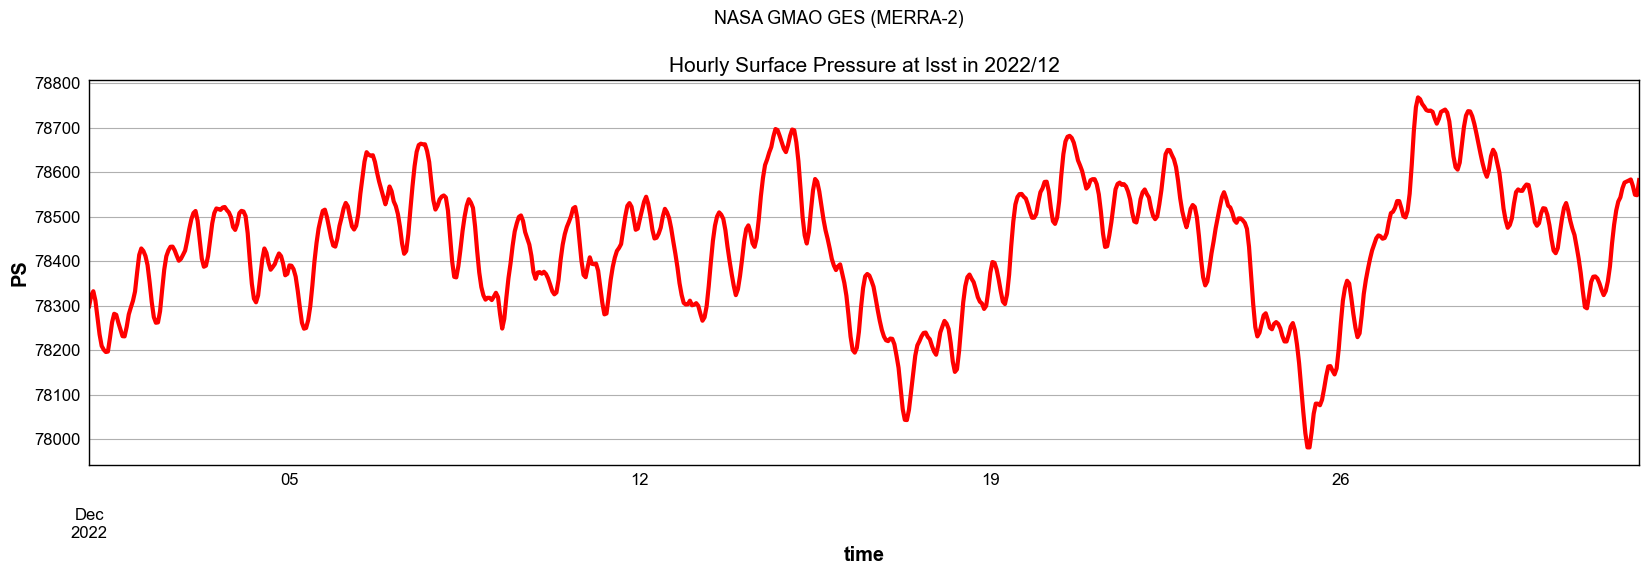

In [38]:
PlotTimeSeries(0,figfile_ps)

###  4.2)  T10
----------------

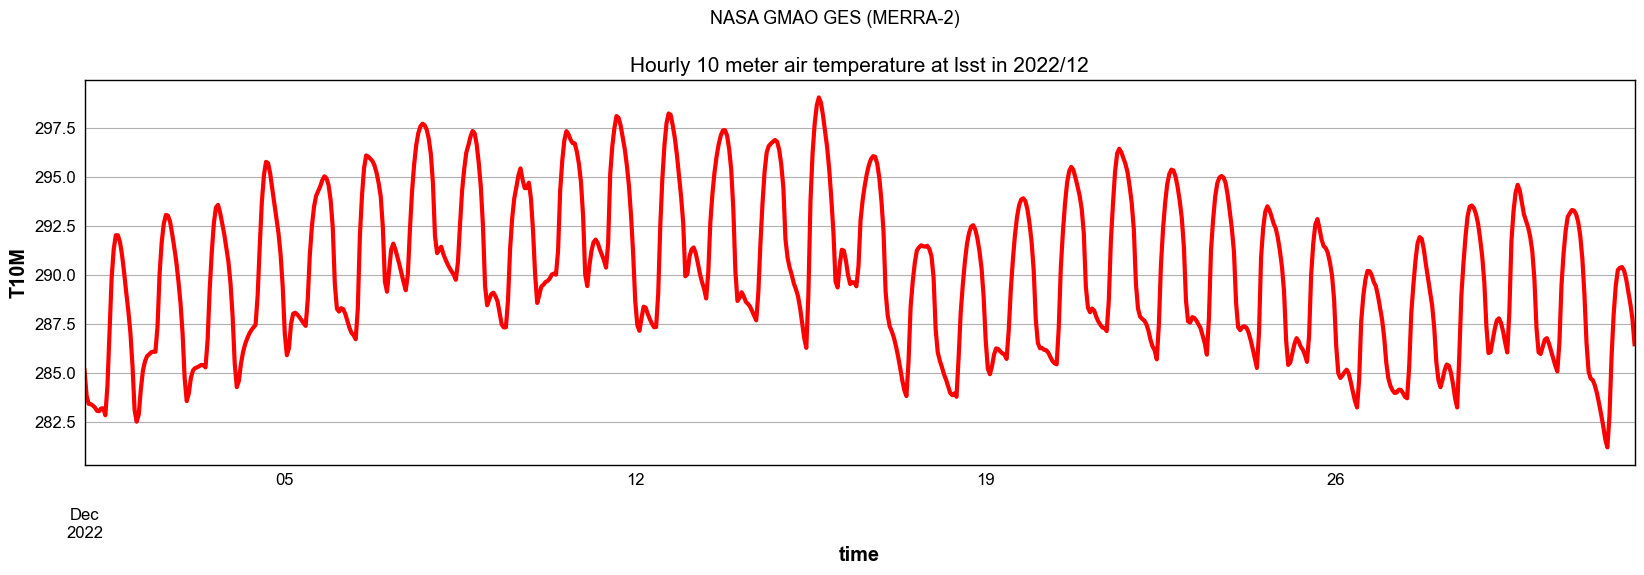

In [39]:
PlotTimeSeries(1,figfile_t10)

### 4.3) t2

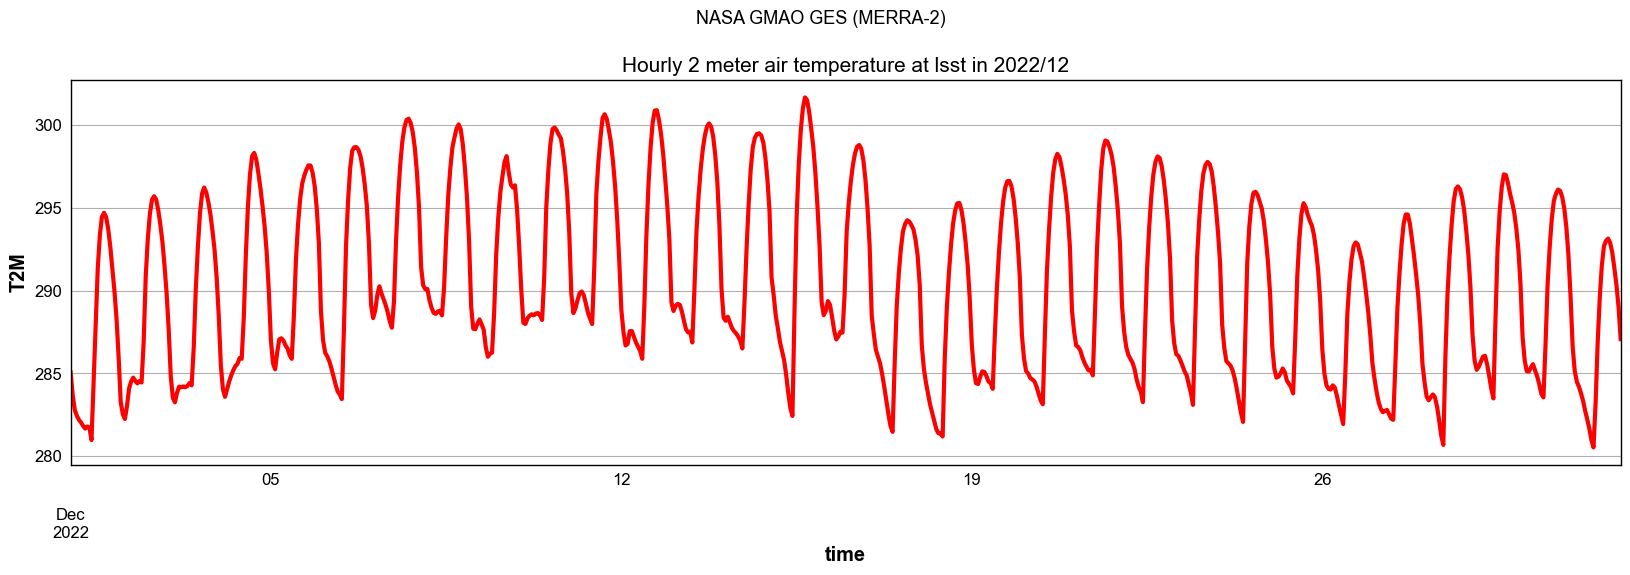

In [40]:
PlotTimeSeries(2,figfile_t2)

### 4.4) to3

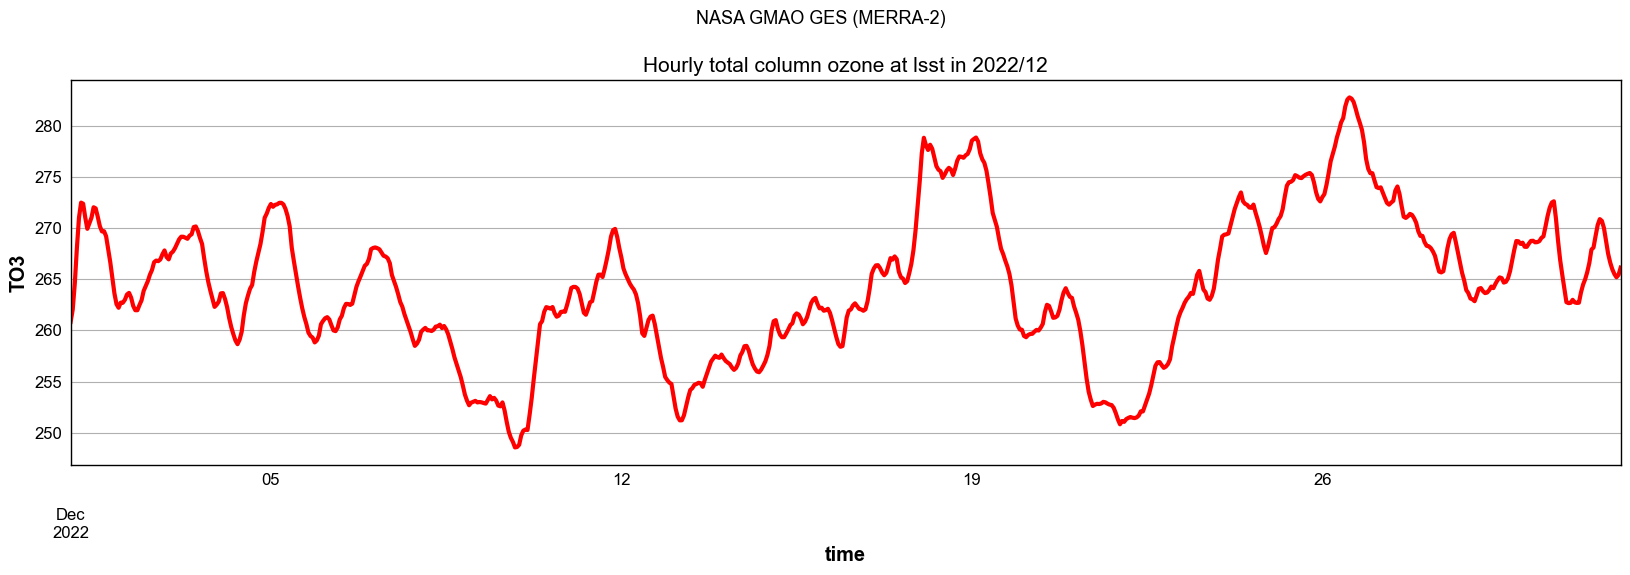

In [41]:
PlotTimeSeries(3,figfile_to3)

### 4.5) tox

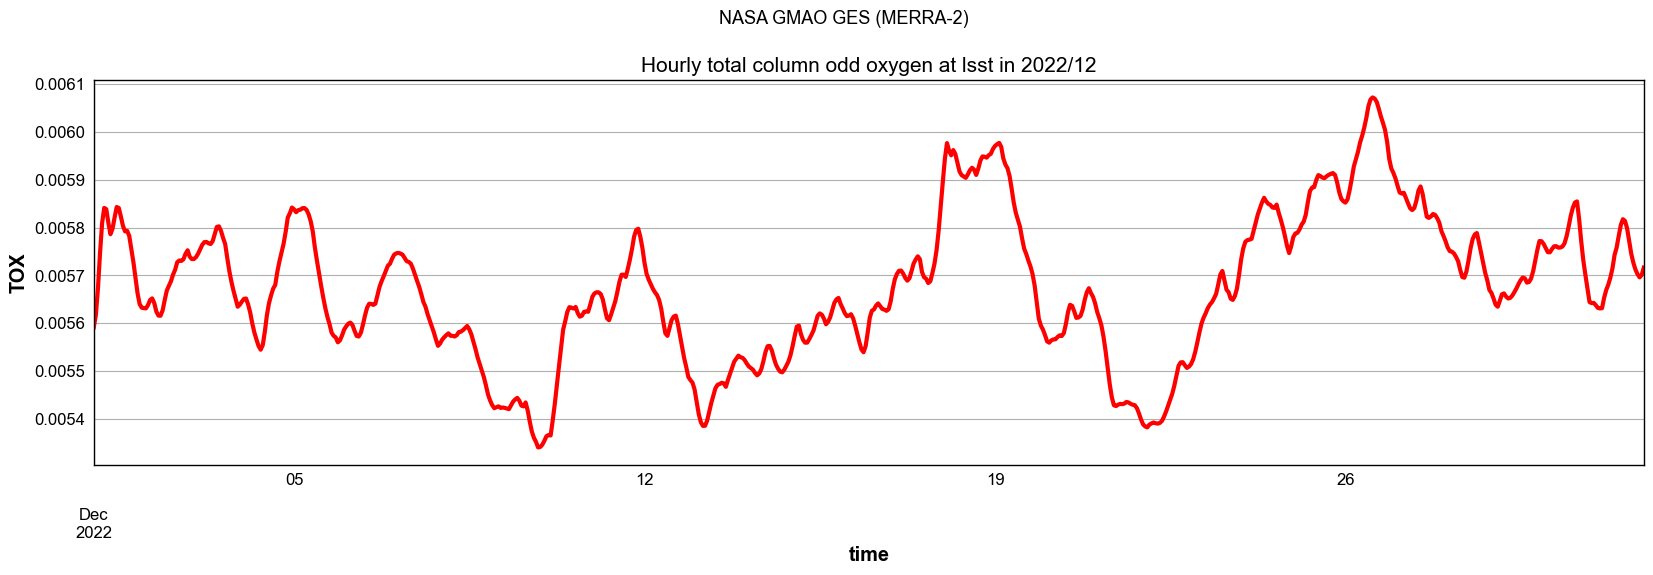

In [42]:
PlotTimeSeries(4,figfile_tox)

### 4.6 TQI

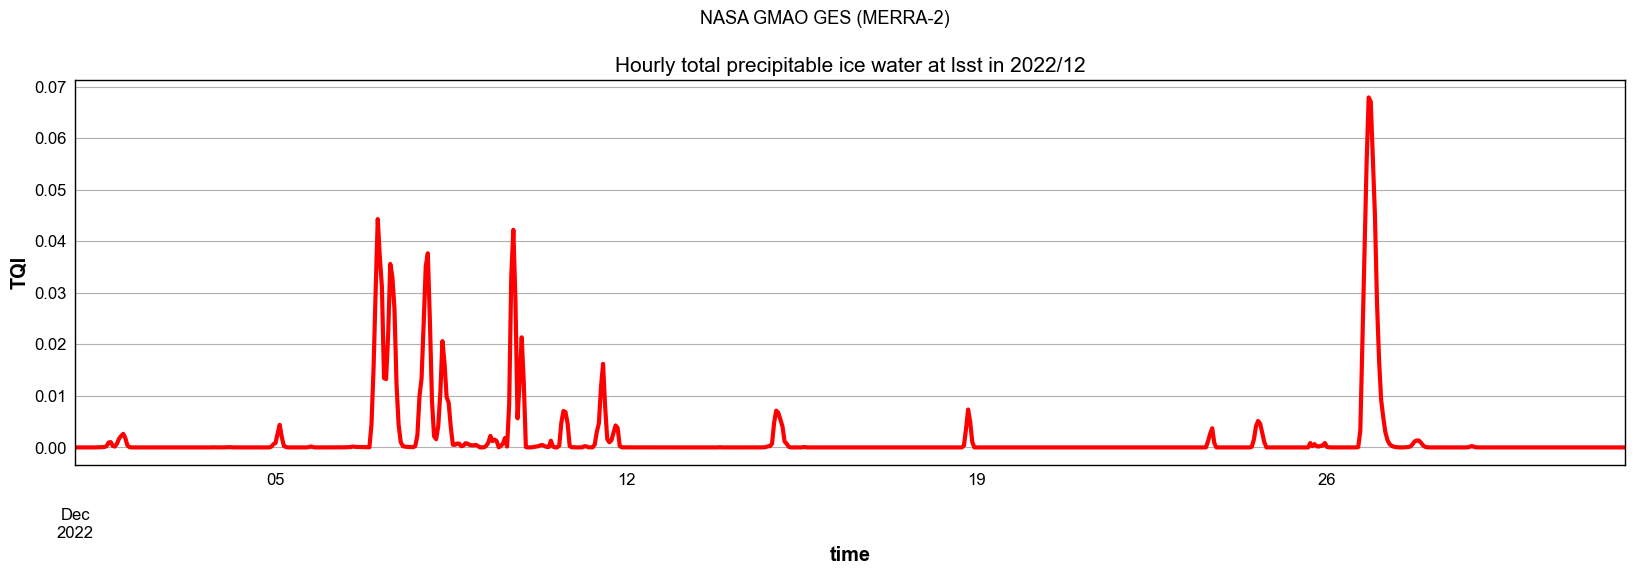

In [43]:
PlotTimeSeries(5,figfile_tqi)

### 4.7) TQL

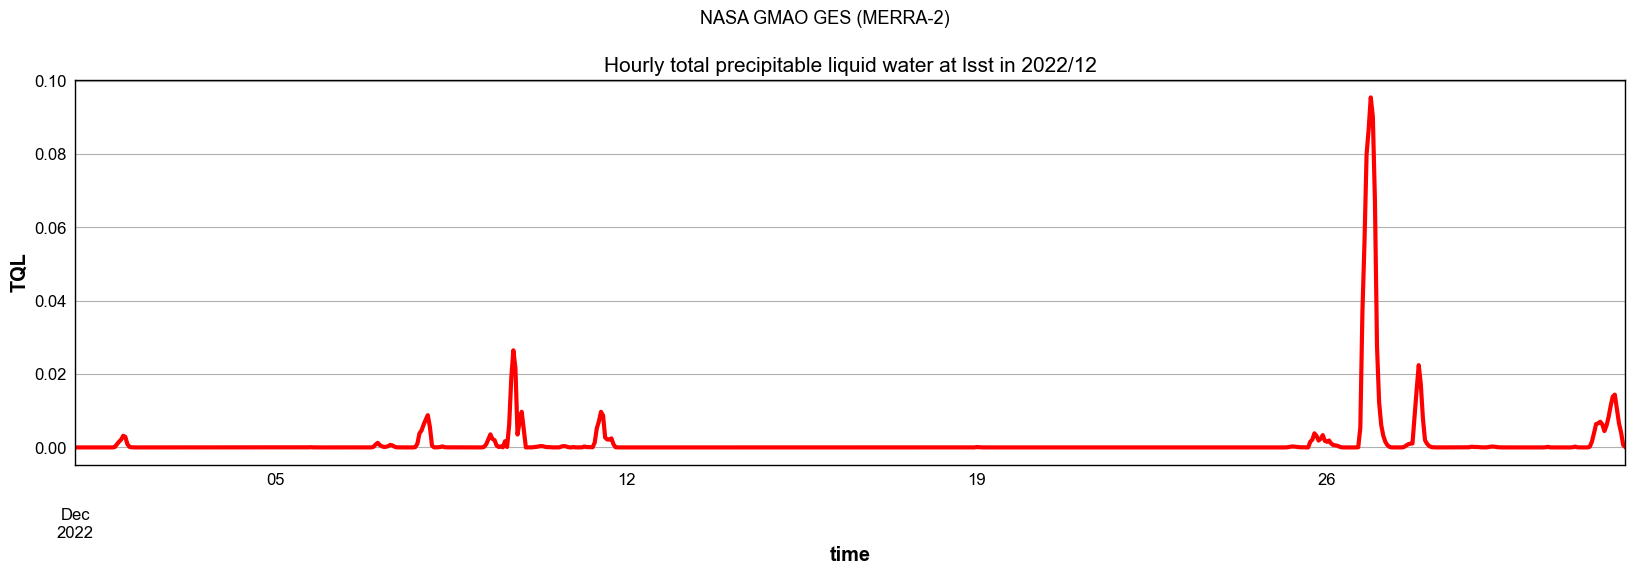

In [44]:
PlotTimeSeries(6,figfile_tql)

### TQV

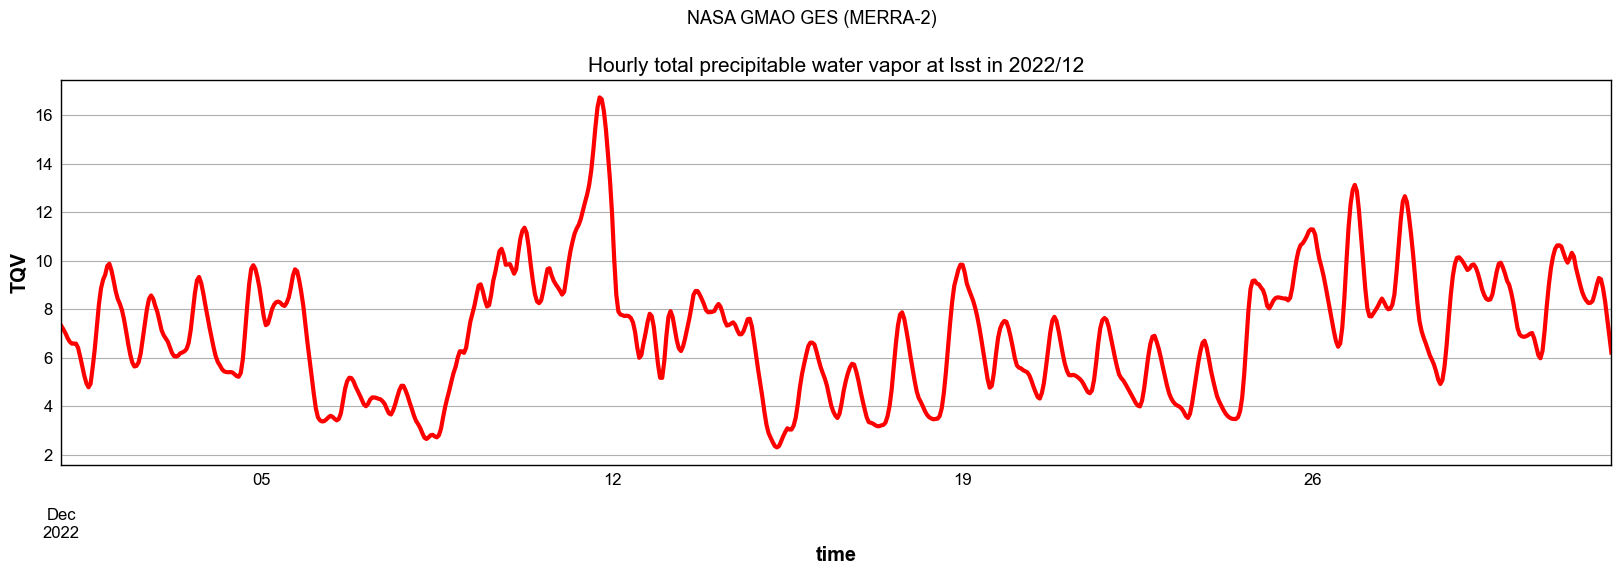

In [45]:
PlotTimeSeries(7,figfile_tqv)

### 4.8) TS

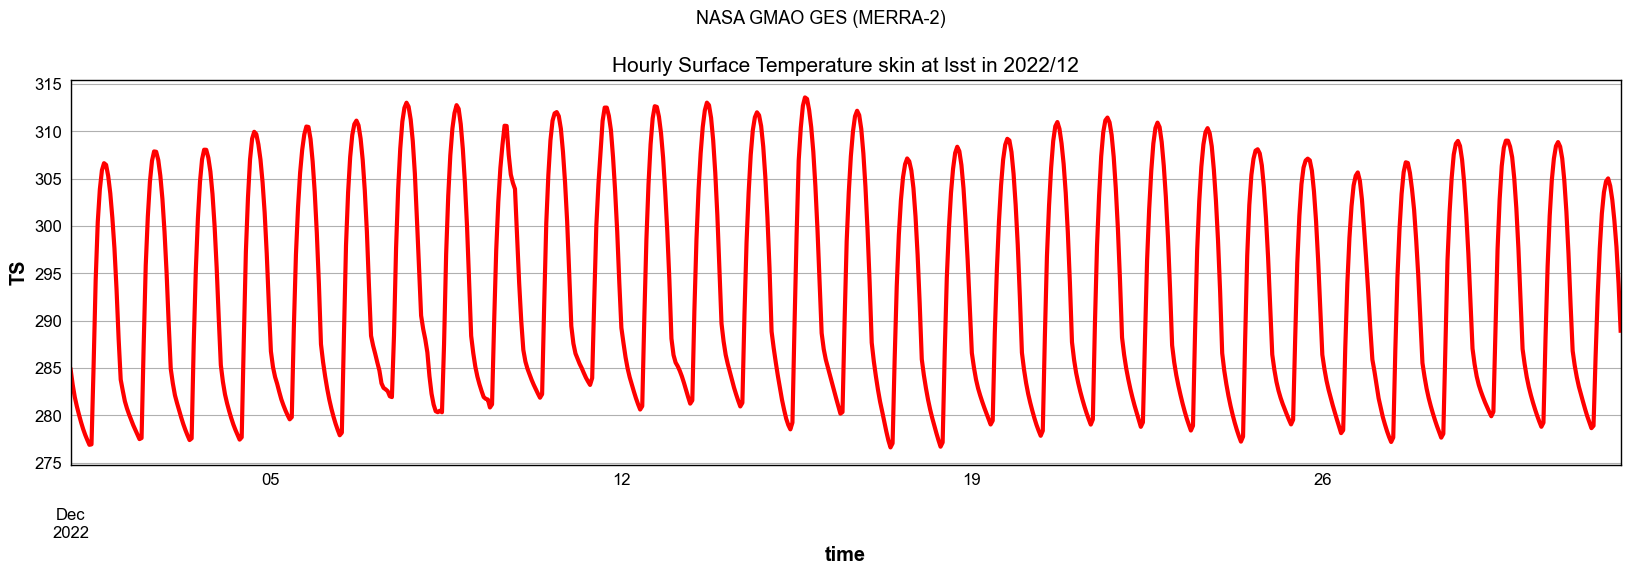

In [46]:
PlotTimeSeries(8,figfile_ts)

### 4.9) um10

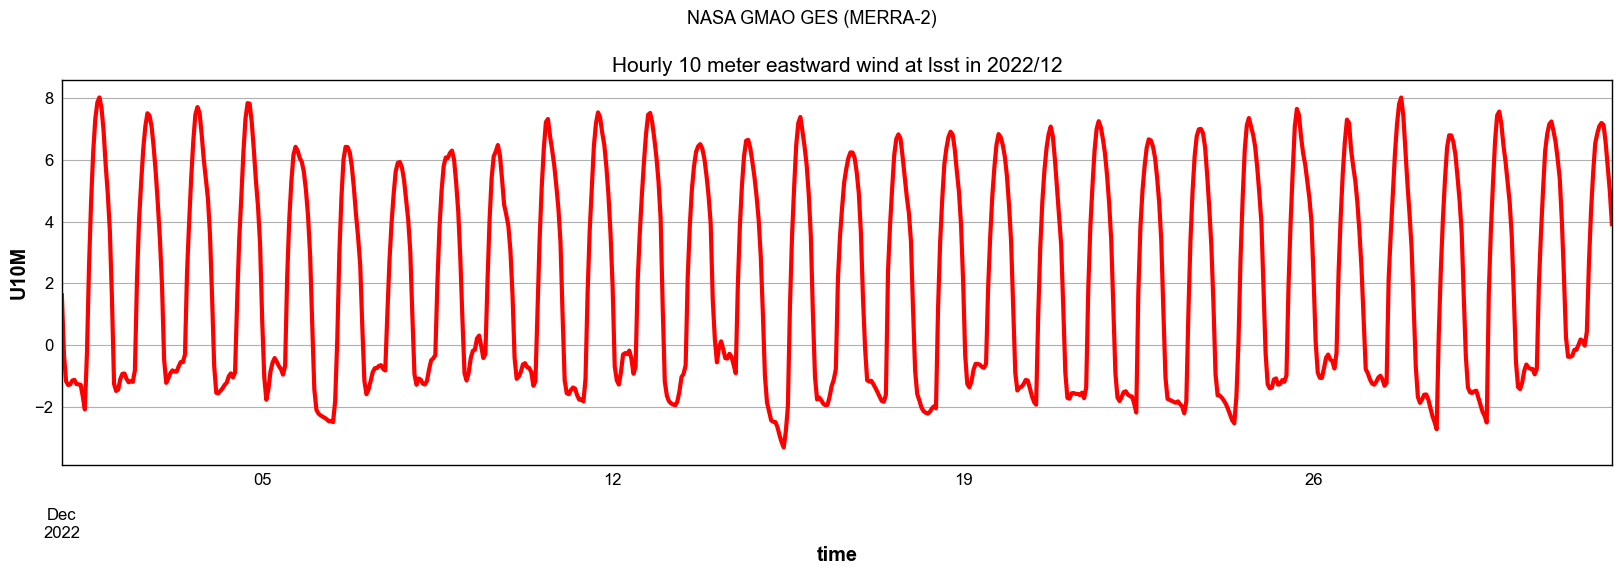

In [47]:
PlotTimeSeries(9,figfile_u10m)

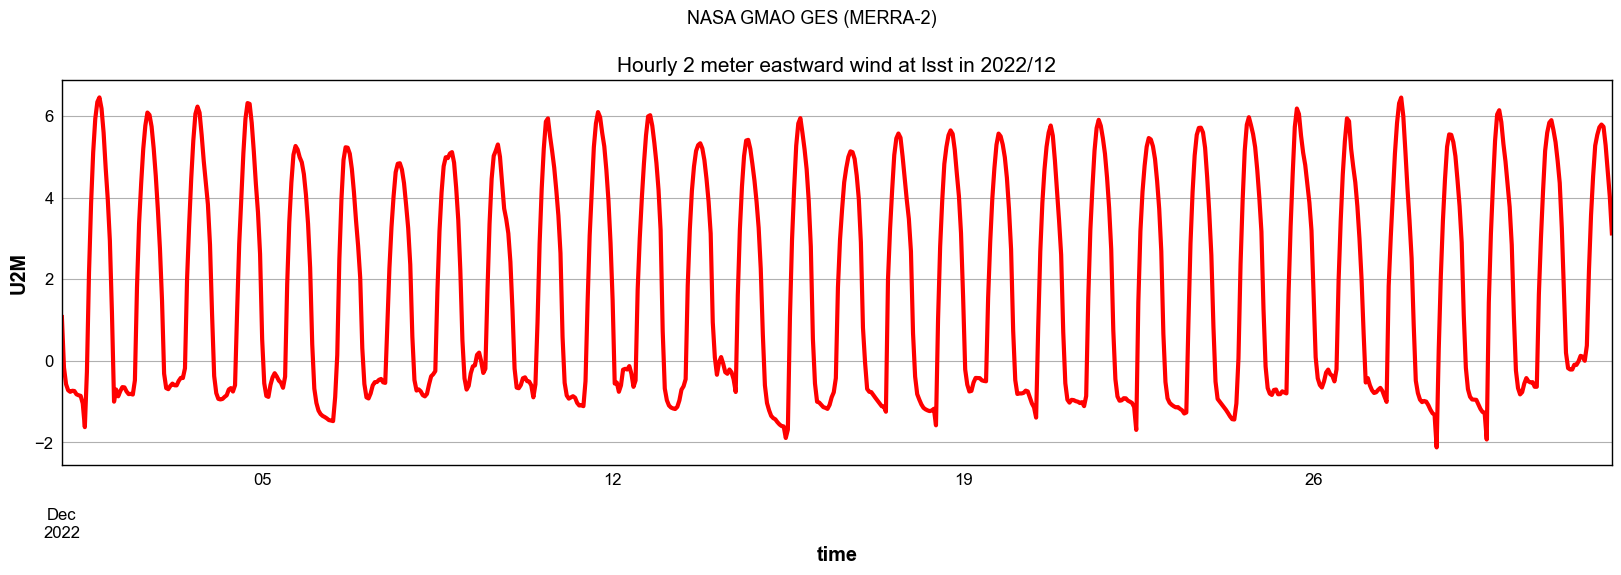

In [48]:
PlotTimeSeries(10,figfile_u2m)

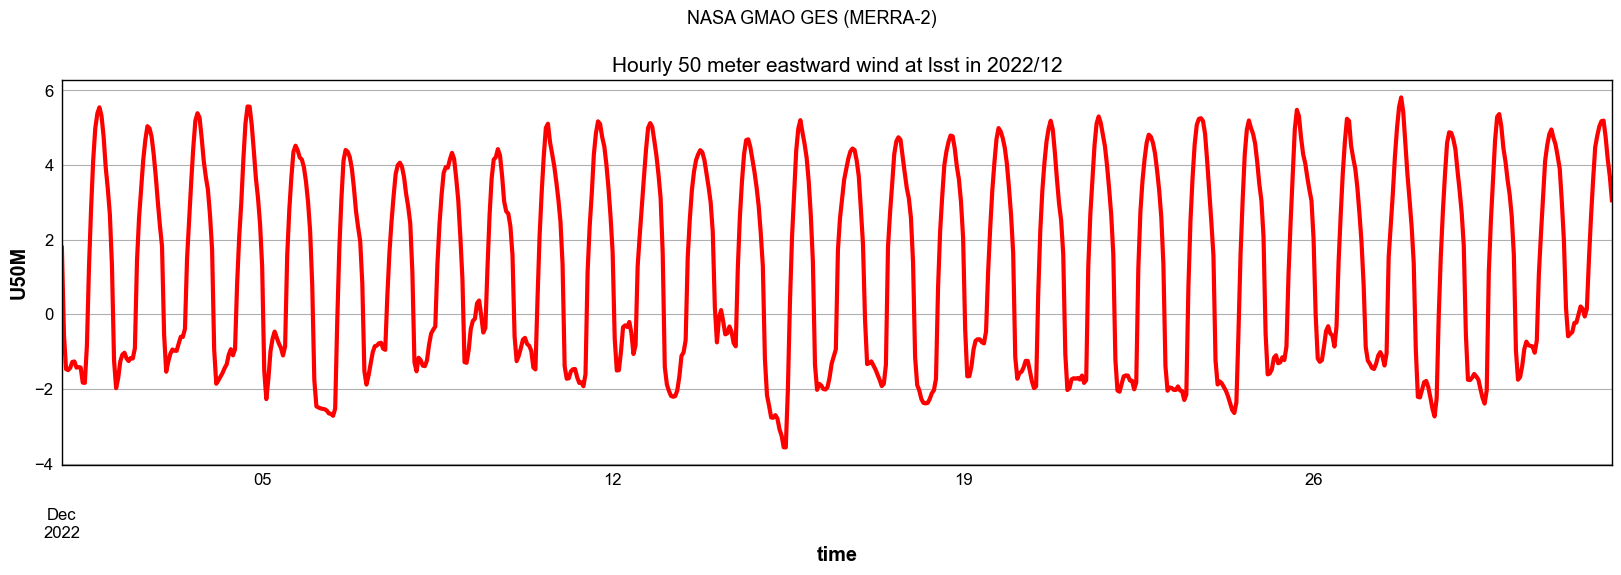

In [49]:
PlotTimeSeries(11,figfile_u50m)

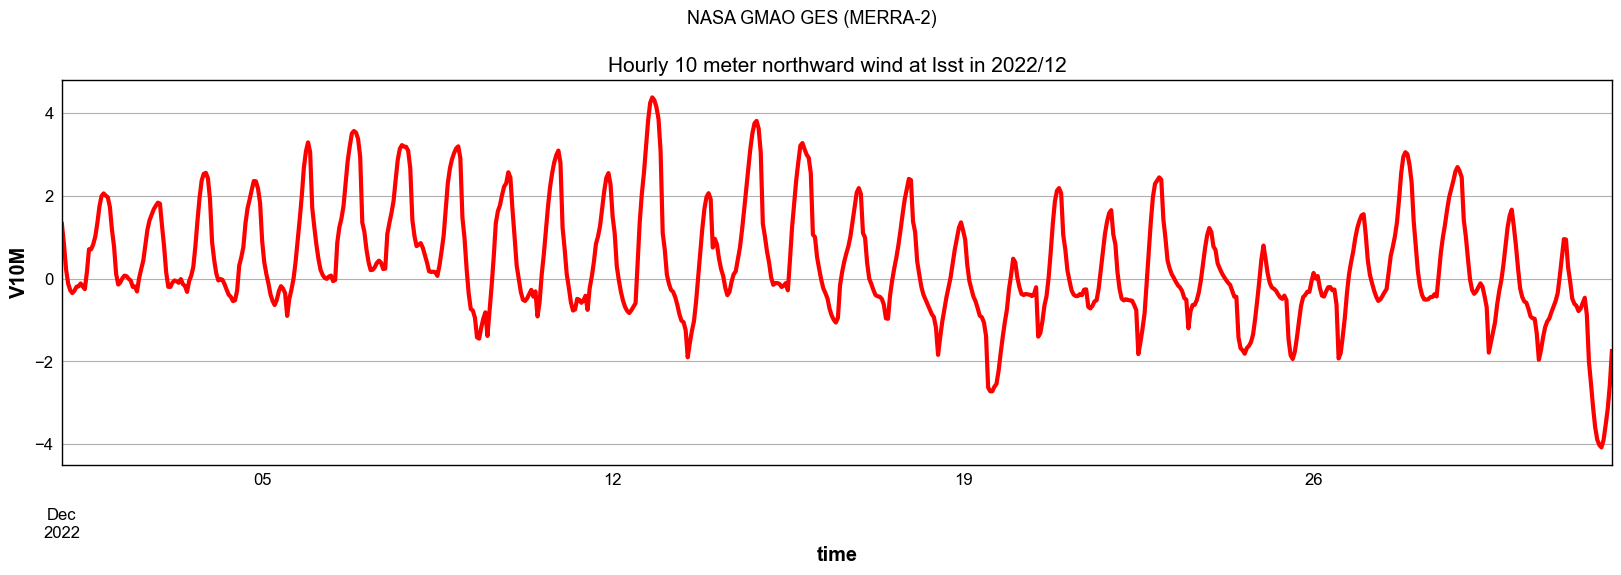

In [50]:
PlotTimeSeries(12,figfile_v10m)

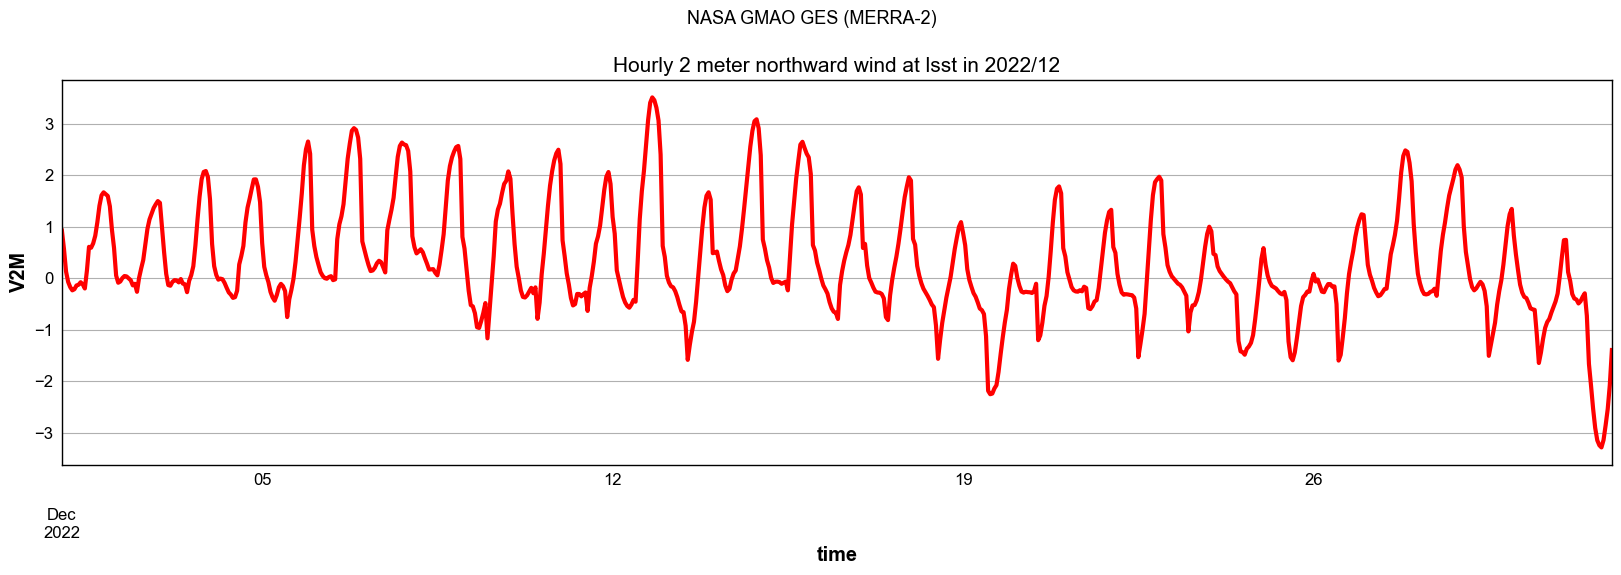

In [51]:
PlotTimeSeries(13,figfile_v2m)

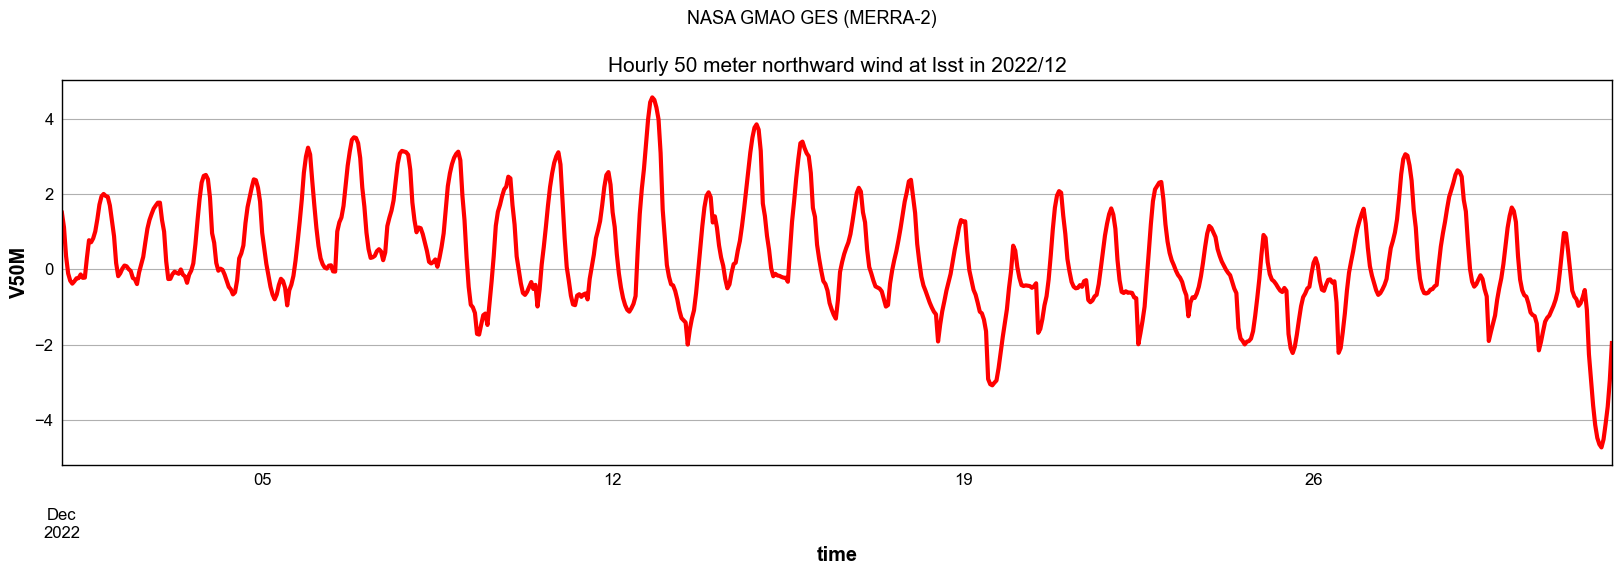

In [52]:
PlotTimeSeries(14,figfile_v50m)

## 5) Output

In [53]:
df_inst1_2d_asm_Nx.index.name='time'
df_inst1_2d_asm_Nx.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,78436.335938,290.151123,290.464417,264.373535,0.005674,0.001826,0.001350,7.012770,293.313477,2.100065,1.820880,1.243917,0.366986,0.296616,0.320451
std,146.080185,3.907310,5.360654,6.995467,0.000150,0.007187,0.007734,2.492181,11.696736,3.418617,2.664572,2.644819,1.359829,1.084633,1.446087
min,77981.851562,281.226501,280.540375,248.565659,0.005340,0.000000,0.000000,2.309113,276.625519,-3.317208,-2.121167,-3.566914,-4.076051,-3.282391,-4.727574
25%,78333.074219,287.119102,285.653618,260.036911,0.005577,0.000000,0.000000,5.089427,282.202858,-1.149033,-0.719391,-1.283000,-0.445746,-0.297930,-0.565751
50%,78452.558594,290.017715,289.688370,263.893021,0.005663,0.000000,0.000000,6.960955,290.301453,1.514040,1.099154,1.315366,0.050472,0.028873,0.058574
75%,78529.562500,293.158813,295.160393,269.117996,0.005772,0.000080,0.000019,8.606302,305.062744,5.572297,4.542421,3.847692,1.214111,0.877426,1.277850
max,78768.445312,299.045685,301.652802,282.758850,0.006073,0.067902,0.095490,16.738832,313.591614,8.027097,6.459955,5.813656,4.375709,3.507474,4.563309


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [54]:
dataset=df_inst1_2d_asm_Nx

In [55]:
dataset.index.name='time'

In [56]:
dataset.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,78436.335938,290.151123,290.464417,264.373535,0.005674,0.001826,0.001350,7.012770,293.313477,2.100065,1.820880,1.243917,0.366986,0.296616,0.320451
std,146.080185,3.907310,5.360654,6.995467,0.000150,0.007187,0.007734,2.492181,11.696736,3.418617,2.664572,2.644819,1.359829,1.084633,1.446087
min,77981.851562,281.226501,280.540375,248.565659,0.005340,0.000000,0.000000,2.309113,276.625519,-3.317208,-2.121167,-3.566914,-4.076051,-3.282391,-4.727574
25%,78333.074219,287.119102,285.653618,260.036911,0.005577,0.000000,0.000000,5.089427,282.202858,-1.149033,-0.719391,-1.283000,-0.445746,-0.297930,-0.565751
50%,78452.558594,290.017715,289.688370,263.893021,0.005663,0.000000,0.000000,6.960955,290.301453,1.514040,1.099154,1.315366,0.050472,0.028873,0.058574
75%,78529.562500,293.158813,295.160393,269.117996,0.005772,0.000080,0.000019,8.606302,305.062744,5.572297,4.542421,3.847692,1.214111,0.877426,1.277850
max,78768.445312,299.045685,301.652802,282.758850,0.006073,0.067902,0.095490,16.738832,313.591614,8.027097,6.459955,5.813656,4.375709,3.507474,4.563309


In [57]:
dataset.head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2022-12-01 00:00:00,78299.273438,285.156067,285.062775,260.830475,0.005591,0.0,3.726454e-07,7.312824,284.836792,1.616450,1.075244,1.786547,1.318497,0.924113,1.502488
2022-12-01 01:00:00,78323.718750,283.859711,283.678925,262.037750,0.005617,0.0,6.658956e-06,7.168751,283.225647,-0.310107,-0.163763,-0.559532,0.826408,0.567914,1.115110
2022-12-01 02:00:00,78332.851562,283.446411,282.786255,264.596619,0.005672,0.0,8.098781e-06,7.009830,281.927795,-1.173777,-0.571425,-1.469569,0.224903,0.127537,0.350055
2022-12-01 03:00:00,78312.007812,283.428314,282.447174,268.057190,0.005746,0.0,3.404915e-06,6.814201,280.943298,-1.294433,-0.720459,-1.495568,-0.119204,-0.071728,-0.109619
2022-12-01 04:00:00,78273.062500,283.354980,282.199707,271.007141,0.005809,0.0,1.200475e-06,6.666037,280.089569,-1.273154,-0.758613,-1.433384,-0.281232,-0.172972,-0.302398


In [58]:
dataset.to_csv(pandas_filename)

In [59]:
saved_dataset=pd.read_csv(pandas_filename)

In [60]:
saved_dataset.head()

,time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
0,2022-12-01 00:00:00,78299.27,285.15607,285.06277,260.83047,0.005591,0.0,3.726455e-07,7.312824,284.83680,1.616450,1.075244,1.786547,1.318497,0.924113,1.502488
1,2022-12-01 01:00:00,78323.72,283.85970,283.67892,262.03775,0.005617,0.0,6.658956e-06,7.168751,283.22565,-0.310107,-0.163763,-0.559532,0.826408,0.567914,1.115110
2,2022-12-01 02:00:00,78332.85,283.44640,282.78625,264.59662,0.005672,0.0,8.098781e-06,7.009830,281.92780,-1.173777,-0.571425,-1.469569,0.224903,0.127537,0.350055
3,2022-12-01 03:00:00,78312.01,283.42830,282.44717,268.05720,0.005746,0.0,3.404915e-06,6.814201,280.94330,-1.294433,-0.720459,-1.495568,-0.119204,-0.071728,-0.109619
4,2022-12-01 04:00:00,78273.06,283.35498,282.19970,271.00714,0.005809,0.0,1.200475e-06,6.666037,280.08957,-1.273154,-0.758613,-1.433384,-0.281232,-0.172972,-0.302398


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [61]:
table = Table.from_pandas(saved_dataset)

In [62]:
table

time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2022-12-01 00:00:00,78299.27,285.15607,285.06277,260.83047,0.00559135,0.0,3.7264545e-07,7.312824,284.8368,1.6164503,1.075244,1.7865468,1.3184966,0.9241131,1.5024883
2022-12-01 01:00:00,78323.72,283.8597,283.67892,262.03775,0.005617177,0.0,6.6589564e-06,7.168751,283.22565,-0.31010687,-0.16376346,-0.55953217,0.8264077,0.56791437,1.1151103
2022-12-01 02:00:00,78332.85,283.4464,282.78625,264.59662,0.0056723403,0.0,8.098781e-06,7.00983,281.9278,-1.1737769,-0.57142496,-1.469569,0.22490299,0.12753731,0.35005504
2022-12-01 03:00:00,78312.01,283.4283,282.44717,268.0572,0.005746193,0.0,3.4049153e-06,6.814201,280.9433,-1.2944325,-0.72045857,-1.4955677,-0.119203866,-0.07172781,-0.10961914
2022-12-01 04:00:00,78273.06,283.35498,282.1997,271.00714,0.0058094924,0.0,1.2004748e-06,6.6660366,280.08957,-1.2731541,-0.7586128,-1.4333842,-0.2812317,-0.17297238,-0.30239797
2022-12-01 05:00:00,78235.82,283.25717,282.04047,272.48053,0.0058413395,0.0,1.755543e-07,6.587419,279.28522,-1.1493505,-0.731729,-1.2760798,-0.35032207,-0.23505163,-0.38012958
2022-12-01 06:00:00,78210.01,283.089,281.82776,272.37115,0.0058387234,0.0,0.0,6.591907,278.5637,-1.1274467,-0.7388854,-1.2650073,-0.29276872,-0.21388936,-0.31669372
2022-12-01 07:00:00,78201.4,283.06995,281.67642,271.0324,0.0058101374,0.0,0.0,6.5875125,277.9438,-1.2636396,-0.8193389,-1.4275252,-0.19673228,-0.14080024,-0.238356
2022-12-01 08:00:00,78196.28,283.2116,281.80295,269.91992,0.005786257,0.0,0.0,6.416826,277.4056,-1.2725976,-0.8420983,-1.4144441,-0.18633324,-0.12652919,-0.23494434


In [63]:
table.write(fits_filename,format='fits',overwrite=True)